# Introducción
Un ecocardiograma es un sonograma del corazon. La echocardiografia se usa rutinariamente para el diagnosi y manejo de pacientes con enfermedades cardiacas conocidas o sospechadas. Es una de las pruebas mas usadas en la cardiologia. Puede proveer una gran cantidad de información, incluyendo el tamaño y forma del corazon, capacidad de bombeo, y la ubicación y severidad del daño al tejido. Un ecocardiograma tambien puede darle a un medico otras estimaciones del funcionamiento cardiaco, como el gasto cardiaco, la fraccion de eyección, y la función diastolica.

Tomaremos en cuenta un estudio realizado por _Kan et al_, que consiste en una muestra de ecocardiogramas de 132 pacientes que han tenido ataques al corazón. Se incluyen varias observaciones obtenidas del ecocardiograma, asi como el tiempo de supervivencia del paciente. Las dos categorias que consideraremos son los pacientes que sobrevivieron o no al primer año despues de sufrir un ataque cardiaco.


# Herramientas
El analisis lo realicé en el lenguaje de programación Python. Para cargar y manipular los datos usé Pandas, la librería mas popular para propositos de manipulación de datos. Para generar visualizaciónes se usó MatPlotLib y Seaborn, dos de los paquetes mas populares para este proposito.

Otras herramientas que usamos son numpy para manipulación númerica y scipy, que contiene subrutinas para pruebas estadisticas. Del paquete SciKit learn se usaron las subrutinas usadas para ajustar los modelos de regresión.

In [1]:
import pandas as pd
import holoviews as hv
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_

Los datos fueron obtenidos del repositorio de datos de la University of California Irvine. El conjunto de datos disponible en linea no es el original, que incluye 350 pacientes, sino una versión alternativa recolectada y donada a UCI por Salzberg.

Las variables incluidas son:
    - `survival`: indica la cantidad de meses que el paciente sobrevivió/ha sobrevivido.
    - `still_alive` indica si el paciente seguia vivo al momento de que se recolectaron los datos.
    - `age_at_heart_attack` indica la edad al que el paciente tuvo el paro cardiaco.
    - `pericardial_effusion` es binario e indica si el paciente tenia fluido en exceso alrededor del corazon.
    - `fractional_shortening` es el acortamiento en el diametro de la ventricula izquierda. Valores mas pequeños son mas anormales.
    - `epss` separacion septal del punto e.
    - `lvdd` medida del tamaño del corazón.
    - `wall_motion_index` mide el movimiento de los segmentos del ventriculo izquierdo.
    - `alive_at_one` indica si el paciente sobrevivió un año despues de su paro cardiaco.
    
Para mantener el trabajo enfocado, nos concentraremos en tres variables: edad, acortamiento de la ventricula y el indice de movimiento. Buscaremos ver la relación que existe entre estas variables y el indice de supervivencia de los pacientes en el primer año:

$$
\begin{split}
A_1\colon & \text{ Edad de los pacientes que sobrevivieron al año} \\
A_2\colon & \text{ Edad de los pacientes que no sobrevivieron al año} \\
B_1\colon & \text{ Movimiento ventriculares de los pacientes que sobrevivieron al año} \\
B_1\colon & \text{ Movimiento ventriculares de los pacientes que sobrevivieron al año} \\
C_1\colon & \text{ Acortamiento ventricular para pacientes sobrevivientes al año} \\
C_1\colon & \text{ Acortamiento ventricular para pacientes no sobrevivientes al año} \\
\end{split}
$$
    

# Analisis
## Analisis inicial
Primero que nada veremos una muestra de los datos para hacernos una idea de su forma. Cargamos los datos, nos deshacemos de las variables que no trataremos, y veremos 5 renglones muestreados aleagoreamente 

In [2]:
df = pd.read_csv(
    'fixed_echocardiogram.csv', encoding = "ISO-8859-1",
    error_bad_lines=False, index_col=0)
df = df.replace('?', None).replace('name', None).astype(float)
df['alive_at_one'][df['alive_at_one'] == 0.0] = 'no'
df['alive_at_one'][df['alive_at_one'] == 1.0] = 'si'

df = df[df['alive_at_one'] != 2]
df_vars = df[['age_at_heart_attack', 'fractional_shortening',
              'wall_motion_score', 'alive_at_one']]
df_vars.sample(5)

,age_at_heart_attack,fractional_shortening,wall_motion_score,alive_at_one
124,48.000000,0.150000,10.000000,si
40,64.800588,0.314922,20.446091,no
122,61.000000,0.180000,11.000000,si
17,58.494026,0.299544,7.161032,no
99,49.341395,0.435156,18.174448,no


Primero observamos algunos datos utiles. La cantidad de pacientes que sobrevivieron al primer año:

In [3]:
df['alive_at_one'].value_counts()

no    184
si    166
Name: alive_at_one, dtype: int64

Ahora vemos nuestros valores medios y desviaciones de muestra para nuestras las tres variables que escogimos:

In [4]:
df_vars = df[['age_at_heart_attack', 'fractional_shortening',
              'wall_motion_score', 'alive_at_one']]
df_vars.columns = ['Edad', 'Acortamiento fraccionario',
                   'Movimiento ventricular', 'Vivo al año']


df_vars.groupby('Vivo al año').agg(['mean', 'std'])

Edad           Acortamiento fraccionario            \
                  mean       std                      mean       std   
Vivo al año                                                            
no           61.858149  7.940153                  0.238587  0.129248   
si           62.755676  8.284627                  0.197249  0.089193   

            Movimiento ventricular            
                              mean       std  
Vivo al año                                   
no                       13.569254  3.674553  
si                       15.071443  6.818312

La primera observación que podemos hacer es que los valores de edad no parecen ser muy diferentes, pero la historia es distinta para el acortamiento fraccional y el movimiento, que parecen ser distintos en ambas categorias. Podemos recurrir a un diagrama de cajas para visualizar como son distintos.

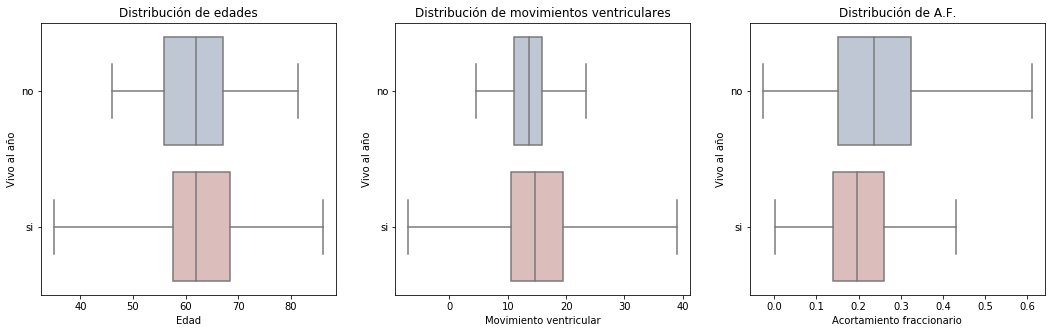

In [5]:
f, axes = plt.subplots(1, 3, figsize=(18, 5))
age_bp = sns.boxplot(x="Edad", y="Vivo al año", data=df_vars,
            whis="range", palette="vlag", ax=axes[0])
m_bp = sns.boxplot(x="Movimiento ventricular", y="Vivo al año", data=df_vars,
            whis="range", palette="vlag", ax=axes[1])
fs_bp = sns.boxplot(x="Acortamiento fraccionario", y="Vivo al año", data=df_vars,
            whis="range", palette="vlag", ax=axes[2])

age_bp.set_title("Distribución de edades")
m_bp.set_title("Distribución de movimientos ventriculares")
fs_bp.set_title("Distribución de A.F.")

print()

Podemos ver que en el caso de la edad las diferencias de las distribuciones es muy ligera. Los otros dos se muestran mas prometedores como indicadores de la supervivencia media de los pacientes.

## Normalidad

Para saber que pruebas podemos usar, necesitamos probar la normalidad de los datos. Para una visualizacion rapida, veremos histogramas para las variables.

Histogramas para pacientes que sobrevivieron:

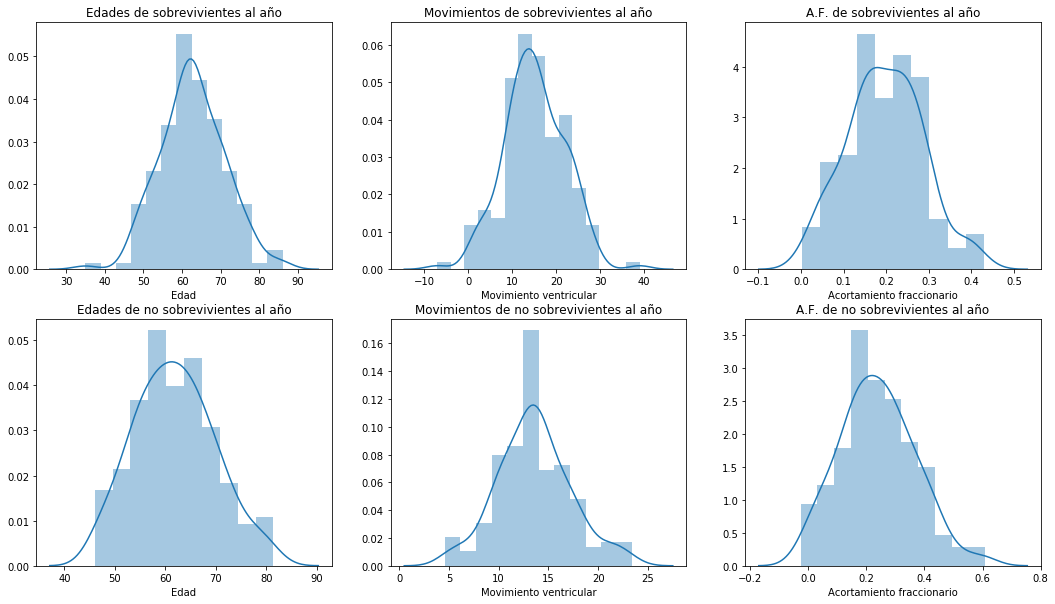

In [6]:
df_alive = df_vars[df_vars['Vivo al año'] == 'si']
df_deceased = df_vars[df_vars['Vivo al año'] == 'no']

f, axes = plt.subplots(2, 3, figsize=(18, 10))

age_hist = sns.distplot(df_alive['Edad'], ax=axes[0][0])
wm_hist = sns.distplot(df_alive['Movimiento ventricular'], ax=axes[0][1])
fs_hist = sns.distplot(df_alive['Acortamiento fraccionario'], ax=axes[0][2])

age_hist.set_title('Edades de sobrevivientes al año')
wm_hist.set_title('Movimientos de sobrevivientes al año')
fs_hist.set_title('A.F. de sobrevivientes al año')

age_hist = sns.distplot(df_deceased['Edad'], ax=axes[1][0])
wm_hist = sns.distplot(df_deceased['Movimiento ventricular'], ax=axes[1][1])
fs_hist = sns.distplot(df_deceased['Acortamiento fraccionario'], ax=axes[1][2])

age_hist.set_title('Edades de no sobrevivientes al año')
wm_hist.set_title('Movimientos de no sobrevivientes al año')
fs_hist.set_title('A.F. de no sobrevivientes al año')
print()

A primera vista los datos parecen prometedores. Ahora realizamos una prueba de shapiro para probar la normalidad de nuestras variables.

In [13]:
alpha = 0.05
for var in ('Edad', 'Movimiento ventricular', 'Acortamiento fraccionario'):
    stat, p = scipy.stats.shapiro(df_alive[var])
    print('Estadistico=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('La muestra de {} para pacientes que sobrevivieron '
              'parece normal'.format(var))
    else:
        print('La muestra de {} para pacientes que sobrevivieron '
              'no parece normal'.format(var))
        
    stat, p = scipy.stats.shapiro(df_deceased[var])
    print('Estadistico=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('La muestra de {} para pacientes que no sobrevivieron ' \
              'parece normal'.format(var))
    else:
        print('La muestra de {} para pacientes que no sobrevivieron ' \
              'no parece normal'.format(var))



Estadistico=0.993, p=0.547
La muestra de Edad para pacientes que sobrevivieron parece normal
Estadistico=0.989, p=0.168
La muestra de Edad para pacientes que no sobrevivieron parece normal
Estadistico=0.989, p=0.242
La muestra de Movimiento ventricular para pacientes que sobrevivieron parece normal
Estadistico=0.988, p=0.114
La muestra de Movimiento ventricular para pacientes que no sobrevivieron parece normal
Estadistico=0.990, p=0.264
La muestra de Acortamiento fraccionario para pacientes que sobrevivieron parece normal
Estadistico=0.990, p=0.207
La muestra de Acortamiento fraccionario para pacientes que no sobrevivieron parece normal


Podemos ver que nuestras cuatro distribuciones pasan la prueba de shapiro, lo que indica que son normales. Ya asumiendo que las distribuciones normales sabemos que es apropiado aplicar pruebas t sobre las variables.

## Pruebas de hipotesis

Vamos a realizar pruebas de hipotesis para probar si las medias de las distribuciones son iguales o si difieren. Realizamos tres pruebas por pares para las tres variables que estamos estudiando.

$$
H_{0}\colon \mu_{X_1} = \mu_{X_2} \\
$$

Para $X_1$ y $X_2$ correspondientes a $A_1$, $A_2$, $B_1$, $B_2$, $C_1$, $C_2$.

Ya que estamos asumiendo normalidad y no conocemos las varianzas de las poblaciones, la prueba que escogí fue la prueba t de Welch. Nuestro estadistico de prueba es

$$
t \quad = \quad {\; \overline{X}_1 - \overline{X}_2 \; \over \sqrt{ \; {s_1^2 \over N_1} \; + \; {s_2^2 \over N_2} \quad }}
$$

Usamos la función `scipy.stats.ttest_ind`, que implementa esta prueba.

In [8]:
alpha = 0.05
print('Con nivel de significancia {}'.format(alpha))
for var in ('Edad', 'Movimiento ventricular', 'Acortamiento fraccionario'):
    print('Realizando la prueba t para {}'.format(var))
    stat, p = scipy.stats.ttest_ind(df_alive[var], df_deceased[var], axis=0,
                                    equal_var=False)
    print('Estadistico=%.3f, p=%.3f' % (stat, p))
    if p < alpha:
        print('Las distribuciones de {} parecen tener media distinta ' \
              '(rechaza h0)'.format(var))
    else:
        print('Las distribuciones de {} parecen ser iguales ' \
              '(no rechaza h0)'.format(var))

Con nivel de significancia 0.05
Realizando la prueba t para Edad
Estadistico=1.032, p=0.303
Las distribuciones de Edad parecen ser iguales (no rechaza h0)
Realizando la prueba t para Movimiento ventricular
Estadistico=2.527, p=0.012
Las distribuciones de Movimiento ventricular parecen tener media distinta (rechaza h0)
Realizando la prueba t para Acortamiento fraccionario
Estadistico=-3.510, p=0.001
Las distribuciones de Acortamiento fraccionario parecen tener media distinta (rechaza h0)


Observamos que las medias de las distribuciones de edad no difieren de forma significativa. Podemos concluir que para nuestra muestra la edad no es indicador de si el paciente sobrevivirá al año.

Las otras dos variables fallan la prueba. Por esto podemos concluir con 95% de significancia que las medias de estas distribuciones difieren, y que podemos usar estas variables como indicadores de riesgo de muerte para pacientes que sufrieron un paro cardiaco.

## Predicción de la mortalidad

Habiendo realizado nuestras pruebas de hipotesis, procedemos con las dos variables con las que tuvimos exito: el movimiento ventricular y el acotamiento  fraccionario. Comenzamos por graficar la dispersion de nuestros puntos dispersados con respecto a la supervivencia.

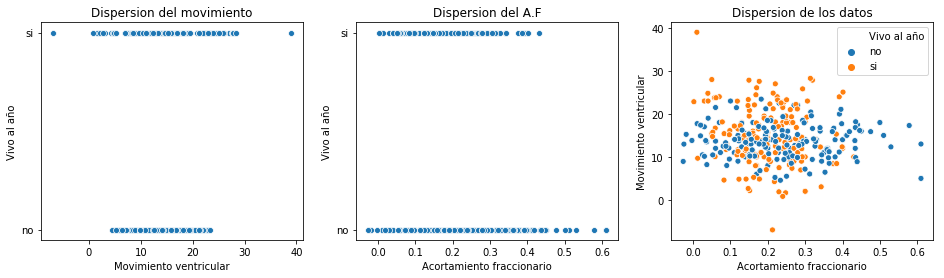

In [9]:
f, axes = plt.subplots(1, 3, figsize=(16, 4))
ax = sns.scatterplot(x="Movimiento ventricular", y="Vivo al año",
                     data=df_vars, ax=axes[0])
ax.set_title('Dispersion del movimiento')
ax = sns.scatterplot(x="Acortamiento fraccionario", y="Vivo al año",
                     data=df_vars, ax=axes[1])
ax.set_title('Dispersion del A.F')
ax = sns.scatterplot(x="Acortamiento fraccionario", y="Movimiento ventricular",
                     hue="Vivo al año", data=df_vars, ax=axes[2])
ax.set_title('Dispersion de los datos')
print()

La primera observación que podemos hacer es que aunque los puntos en ciertas partes pueden parecen ser bastante homogeneos, hay secciones donde se notan mas puntos de un color o del otro. 

Para intentar clasificar los puntos, usaremos un modelo lineal de regresión logistica simple. El paquete SKLearn implementa este modelo para nuestro uso. 

Separaremos los datos en conjuntos de entrenamiento y prueba para poder comprobar nuestro trabajo.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_vars.iloc[:, 1:-1], df_vars.iloc[:, -1], test_size=0.2)

print('Tamaño del conjunto de entrenamiento: {}'.format(X_train.shape[0]))
print('Tamaño del conjunto de prueba: {}'.format(X_test.shape[0]))


Tamaño del conjunto de entrenamiento: 280
Tamaño del conjunto de prueba: 70


Ajustamos los modelos. Ya que tenemos esto, revisamos la precision de nuestro clasificador en el conjunto de prueba. Imprimimos ademas la mátriz de confusión para ver el comportamiento del clasificador lineal.
Comenzamos por 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression(solver='liblinear')

lr.fit(np.expand_dims(X_train.iloc[:, 0].values, 1), y_train)

y_pred = lr.predict(np.expand_dims(X_test.iloc[:, 0], 1))

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                index=['No', 'Si'], columns=['No', 'Si'])
display(confusion_matrix)
print(classification_report(y_test, y_pred))

,No,Si
No,26,12
Si,19,13


              precision    recall  f1-score   support

          no       0.58      0.68      0.63        38
          si       0.52      0.41      0.46        32

   micro avg       0.56      0.56      0.56        70
   macro avg       0.55      0.55      0.54        70
weighted avg       0.55      0.56      0.55        70



Este conjunto de datos tiene la caracteristica de que tiende ser mas facil predecir casos negativos que positivos correctamente. Es decir que el modelo se ajustó de forma que es detecta la mayoria de los casos negativos correctamente, pero tiene dificultades para detectar casos positivos correctamente. Esto puede ser debido a la naturaleza de los datos o simplemente porque la muestra es muy pequeña.

Esto se refleja en el clasificador resultante. Aunque las precision en general no es mucho mejor que la de elegir aleatoreamente, si el clasificador predice que un valor es falso, el clasificador detectará esto un 68% de las veces. Este factor de recuerdo posiblemente podria ser mejor con una cantidad mayor de datos. Un factor de recuerdo mayor haria que el echocardiograma pudiera ser un metodo efectivo para descartar pacientes que probablemente no estén en riesgo. Con el conjunto de datos actual, sin embargo, el clasificador como existe actualmente no es suficiente para tomar decisiones concretas con niveles de confianza significativos.

# Conclusión

A partir de pruebas de hipotesis pudimos observar que tanto el movimiento de la pared vascular como el achicamiento fraccional son factores que pueden indicar un riesgo de mortalidad en el periodo de un año posterior a un paro cardiaco. Similarmente vimos que la edad no es un factor de gran ayuda al momento de predecir este riesgo.

Aunque efectivamente encontramos que estas dos variables se correlacionan con la mortalidad, no son suficientes para ajustar un modelo que pueda predecir satisfactoriamente la mortalidad a un nivel que pueda ser especialmente util. Sin embargo terminamos con la conclusión de que estas medidas obtenidas del echocardiograma pueden ser suficientes para indicarle a un médico que un paciente necesitará cuidado especial.

